In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt




In [3]:
class FER2013LabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Emotion classes (based on the FER2013 dataset)
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
        
        # Prepare the image paths and corresponding labels
        self.image_paths = []
        self.labels = []
        
        # Loop through each emotion subfolder and assign labels
        for idx, emotion in enumerate(self.classes):
            emotion_dir = os.path.join(root_dir, emotion)
            for filename in os.listdir(emotion_dir):
                if filename.endswith('.jpg'):  # or '.png' depending on file type
                    self.image_paths.append(os.path.join(emotion_dir, filename))
                    self.labels.append(idx)  # Label based on folder (Anger=0, Disgust=1, etc.)

        self.dataset = pd.DataFrame({
                'image_paths': self.image_paths,
                'labels': self.labels
            })


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label
    

# Usage example
train_data = FER2013LabelDataset(root_dir=r'archive/train/', transform=transforms.ToTensor())
test_data = FER2013LabelDataset(root_dir=r'archive/test/', transform=transforms.ToTensor())





In [4]:
tensor = train_data[1][0]
print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([1, 48, 48])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


visualizing label assigment.

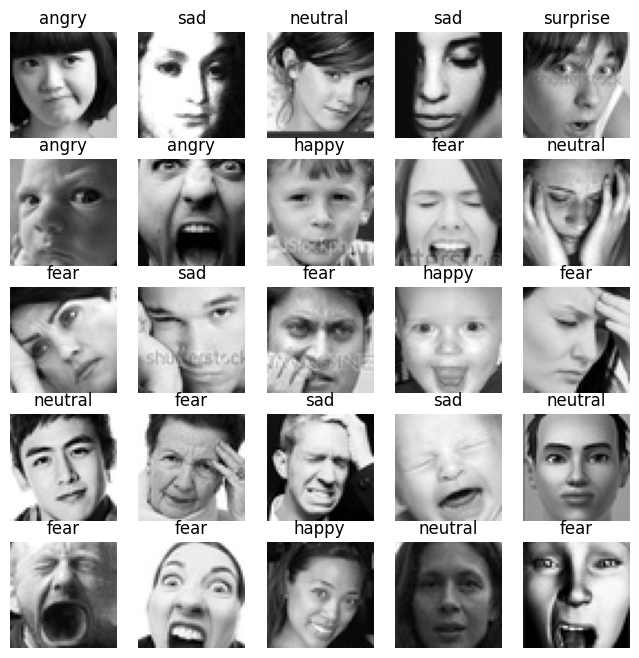

In [5]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [14]:

import torch.nn as nn
import torch.nn.functional as F


class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (48x48) → (48x48)
        self.pool1 = nn.MaxPool2d(2, 2)                          # (48x48) → (24x24)
    
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (24x24) → (24x24)
        self.pool2 = nn.MaxPool2d(2, 2)                           # (24x24) → (12x12)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # (12x12) → (12x12)
        self.pool3 = nn.MaxPool2d(2, 2)                           # (12x12) → (6x6)
        

        self.flattened_size = 64 * 6 * 6
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout_fc = nn.Dropout(0.2)  # Standard dropout in fully connected

        self.output = nn.Linear(64, 7)  # 7 emotion classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
       

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.view(-1, self.flattened_size)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)

        x = self.output(x)
        return x


In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(f"Using device: {device}")

In [ ]:
model = EmotionCNN()
#model.to(device) # trying to train on gpu
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [16]:
from tqdm import tqdm 

# Assuming you already have the train_data and test_data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # Corrected to use test_data

EPOCHS = 9
for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Create a tqdm progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")

    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device) ## for gp 
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy (if necessary)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update the progress bar description
        progress_bar.set_postfix(loss=running_loss/len(train_loader), 
                                 accuracy=correct_predictions/total_predictions)

    # Print Epoch summary
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")


Epoch 1/9: 100%|██████████| 449/449 [01:00<00:00,  7.38batch/s, accuracy=0.287, loss=1.74]  


Epoch 1/9 - Loss: 1.7405, Accuracy: 0.2869


Epoch 2/9: 100%|██████████| 449/449 [01:00<00:00,  7.38batch/s, accuracy=0.397, loss=1.55] 


Epoch 2/9 - Loss: 1.5546, Accuracy: 0.3971


Epoch 3/9: 100%|██████████| 449/449 [01:05<00:00,  6.87batch/s, accuracy=0.44, loss=1.45]  


Epoch 3/9 - Loss: 1.4544, Accuracy: 0.4404


Epoch 4/9: 100%|██████████| 449/449 [01:06<00:00,  6.71batch/s, accuracy=0.472, loss=1.38] 


Epoch 4/9 - Loss: 1.3773, Accuracy: 0.4719


Epoch 5/9: 100%|██████████| 449/449 [01:12<00:00,  6.18batch/s, accuracy=0.498, loss=1.32] 


Epoch 5/9 - Loss: 1.3154, Accuracy: 0.4980


Epoch 6/9: 100%|██████████| 449/449 [01:05<00:00,  6.83batch/s, accuracy=0.515, loss=1.28] 


Epoch 6/9 - Loss: 1.2763, Accuracy: 0.5152


Epoch 7/9: 100%|██████████| 449/449 [01:06<00:00,  6.72batch/s, accuracy=0.532, loss=1.23] 


Epoch 7/9 - Loss: 1.2347, Accuracy: 0.5316


Epoch 8/9: 100%|██████████| 449/449 [01:07<00:00,  6.64batch/s, accuracy=0.541, loss=1.2]  


Epoch 8/9 - Loss: 1.2022, Accuracy: 0.5414


Epoch 9/9: 100%|██████████| 449/449 [02:15<00:00,  3.33batch/s, accuracy=0.551, loss=1.18] 

Epoch 9/9 - Loss: 1.1784, Accuracy: 0.5509


In [20]:
# Evaluate on test data
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
true_labels = []  # To store the true labels
predicted_labels = []  # To store the predicted labels


In [22]:
with torch.no_grad():
    for images, labels in test_loader:
        
        
        # Forward pass to get the predictions
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Collect true and predicted labels for confusion matrix
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Print test summary
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Test Loss: 2.4156, Test Accuracy: 0.5361


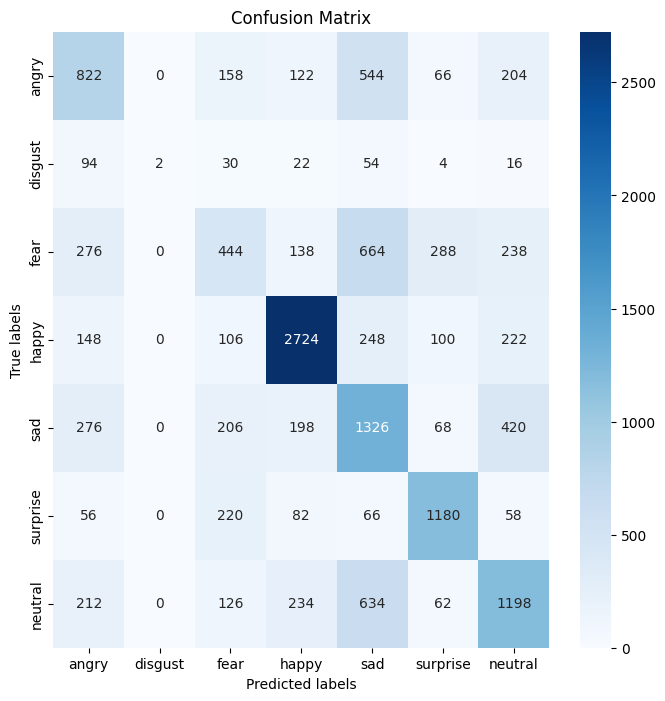

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.classes, yticklabels=train_data.classes, ax=ax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
torch.save(model.state_dict(), "emotion_modelv2.536.pth")
print("Model saved as 'emotion_model2.536.pth'")

Model saved as 'emotion_model2.536.pth'
